<a href="https://colab.research.google.com/github/LochieLinks/IOD-2022/blob/main/Catboost_final_v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --user --upgrade catboost
!pip install --user --upgrade ipywidgets
!pip install shap
!pip install sklearn
!pip install --upgrade numpy
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
import IPython
from google.colab import output

import catboost

import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
from catboost import *
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import tree

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


import xgboost as xgb

from catboost import CatBoostClassifier

#NEEDED FOR STACKING CLASSIFEIR
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv ('/WA_Fn-UseC_-HR-Employee-Attrition.csv')

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# Data Cleaning / EDA

In [ ]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [ ]:
df.shape

(1470, 35)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [ ]:
from sklearn.preprocessing import LabelEncoder
print('Categorical columns: ')
for col in df.columns:
    if df[col].dtype == 'object':
        values = df[col].value_counts()
        values = dict(values)
        
        print(str(col))
        label = LabelEncoder()
        label = label.fit(df[col])
        df[col] = label.transform(df[col].astype(str))
        
        new_values = df[col].value_counts()
        new_values = dict(new_values)
        
        value_dict = {}
        i=0
        for key in values:
            value_dict[key] = list(new_values)[i]
            i+= 1
        print(value_dict)

Categorical columns: 
Attrition
{'No': 0, 'Yes': 1}
BusinessTravel
{'Travel_Rarely': 2, 'Travel_Frequently': 1, 'Non-Travel': 0}
Department
{'Research & Development': 1, 'Sales': 2, 'Human Resources': 0}
EducationField
{'Life Sciences': 1, 'Medical': 3, 'Marketing': 2, 'Technical Degree': 5, 'Other': 4, 'Human Resources': 0}
Gender
{'Male': 1, 'Female': 0}
JobRole
{'Sales Executive': 7, 'Research Scientist': 6, 'Laboratory Technician': 2, 'Manufacturing Director': 4, 'Healthcare Representative': 0, 'Manager': 3, 'Sales Representative': 8, 'Research Director': 5, 'Human Resources': 1}
MaritalStatus
{'Married': 1, 'Single': 2, 'Divorced': 0}
Over18
{'Y': 0}
OverTime
{'No': 0, 'Yes': 1}


In [ ]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,1102,2,1,2,1,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,1,279,1,8,1,1,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,2,1373,1,2,2,4,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,1,1392,1,3,4,1,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,0,2,591,1,2,1,3,1,7,...,4,80,1,6,3,3,2,2,2,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1470 non-null   int64
 1   Attrition                 1470 non-null   int64
 2   BusinessTravel            1470 non-null   int64
 3   DailyRate                 1470 non-null   int64
 4   Department                1470 non-null   int64
 5   DistanceFromHome          1470 non-null   int64
 6   Education                 1470 non-null   int64
 7   EducationField            1470 non-null   int64
 8   EmployeeCount             1470 non-null   int64
 9   EmployeeNumber            1470 non-null   int64
 10  EnvironmentSatisfaction   1470 non-null   int64
 11  Gender                    1470 non-null   int64
 12  HourlyRate                1470 non-null   int64
 13  JobInvolvement            1470 non-null   int64
 14  JobLevel                  1470 non-null 

In [ ]:
df.corr()['Attrition'].sort_values()

TotalWorkingYears          -0.171063
JobLevel                   -0.169105
YearsInCurrentRole         -0.160545
MonthlyIncome              -0.159840
Age                        -0.159205
YearsWithCurrManager       -0.156199
StockOptionLevel           -0.137145
YearsAtCompany             -0.134392
JobInvolvement             -0.130016
JobSatisfaction            -0.103481
EnvironmentSatisfaction    -0.103369
WorkLifeBalance            -0.063939
TrainingTimesLastYear      -0.059478
DailyRate                  -0.056652
RelationshipSatisfaction   -0.045872
YearsSinceLastPromotion    -0.033019
Education                  -0.031373
PercentSalaryHike          -0.013478
EmployeeNumber             -0.010577
HourlyRate                 -0.006846
BusinessTravel              0.000074
PerformanceRating           0.002889
MonthlyRate                 0.015170
EducationField              0.026846
Gender                      0.029453
NumCompaniesWorked          0.043494
Department                  0.063991
J

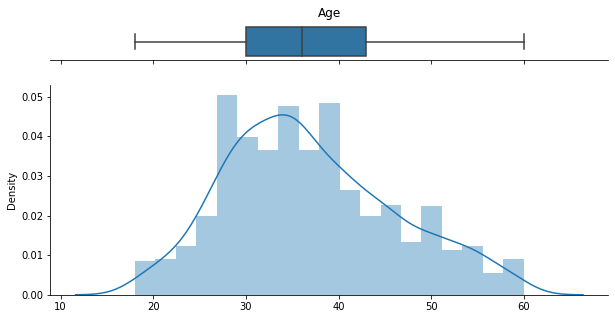

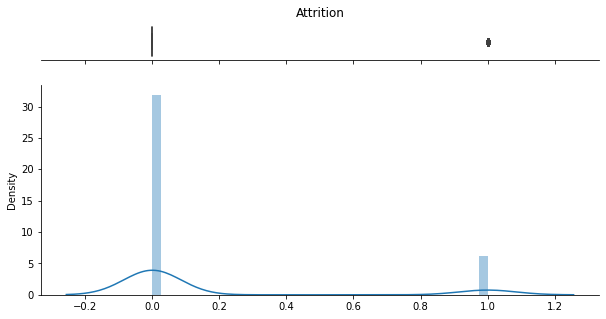

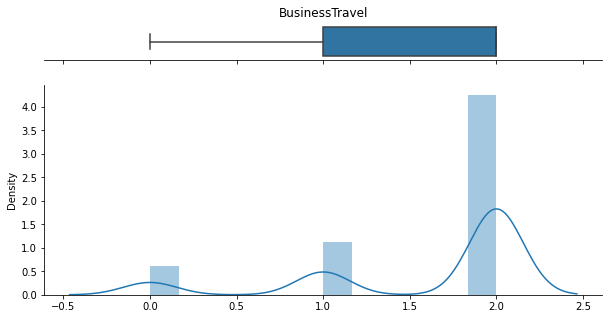

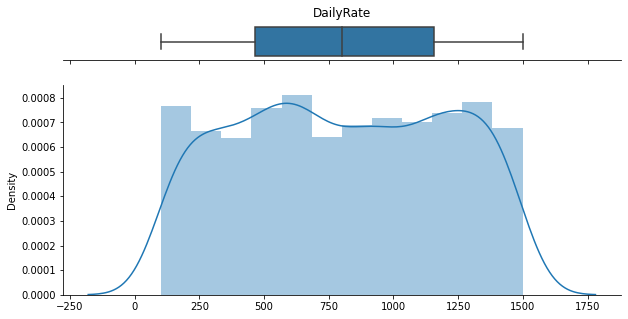

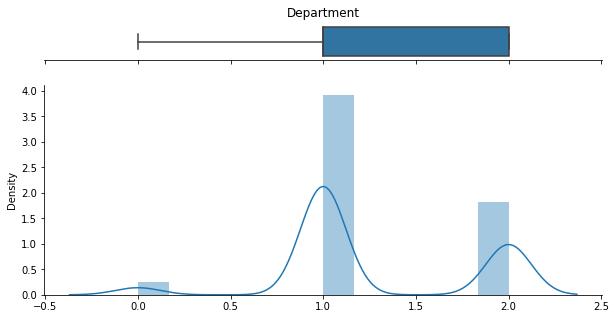

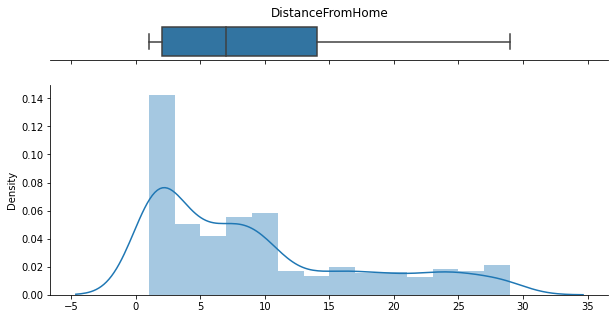

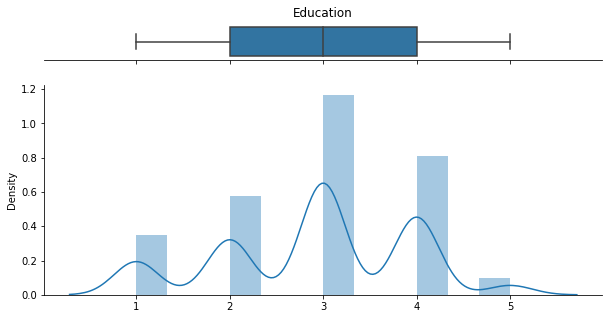

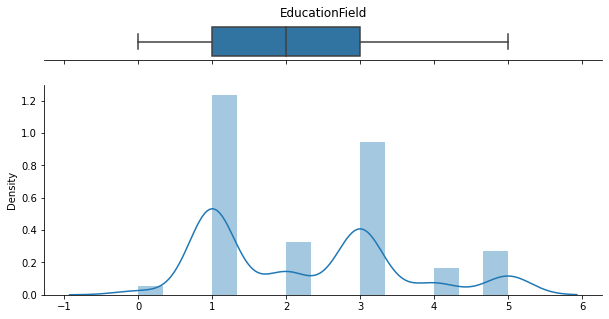

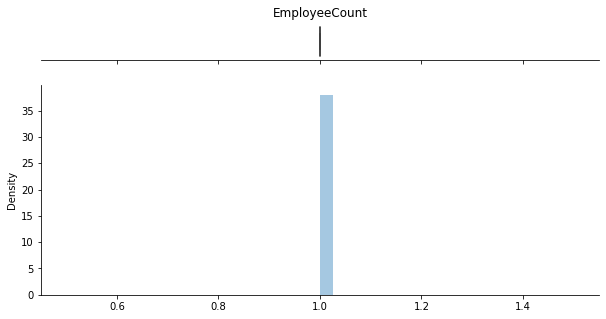

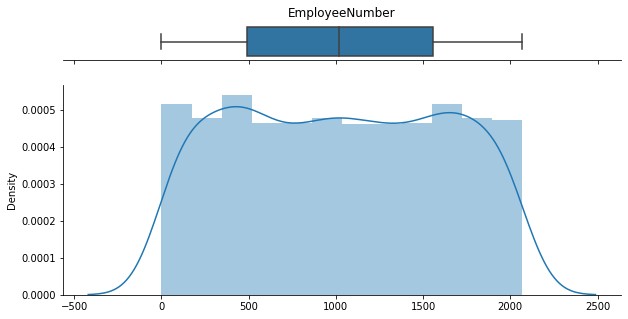

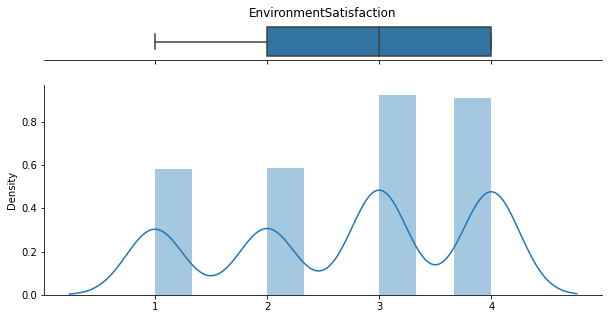

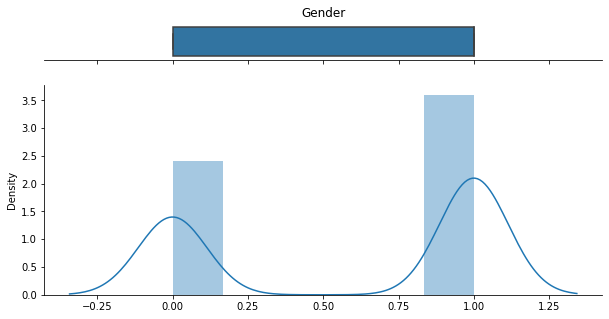

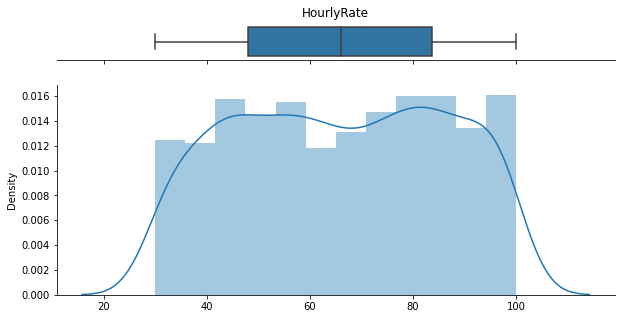

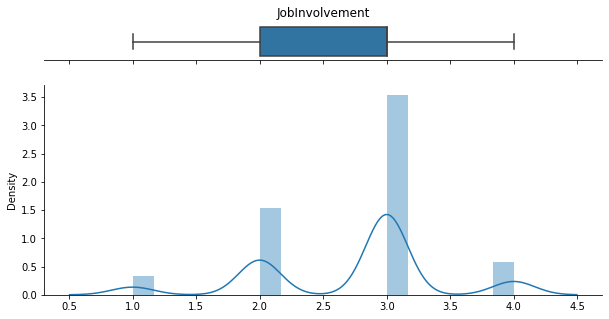

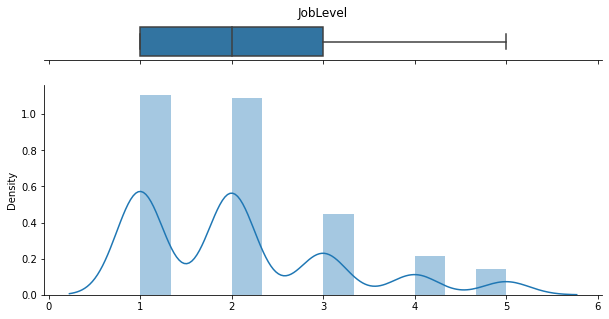

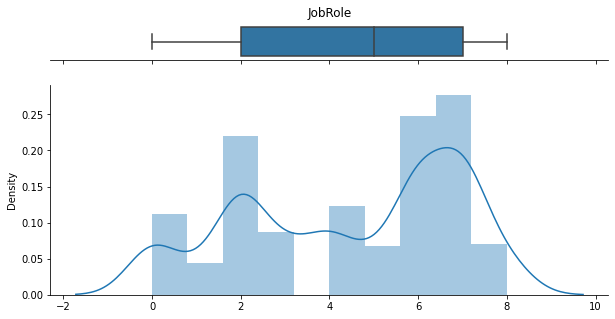

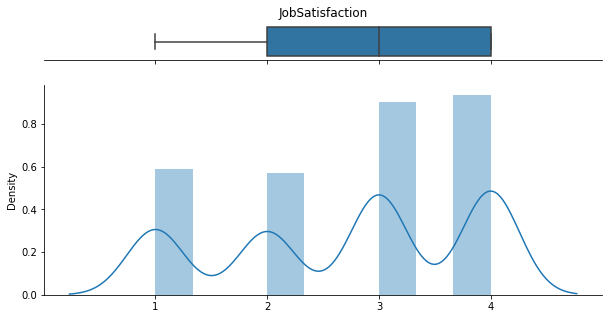

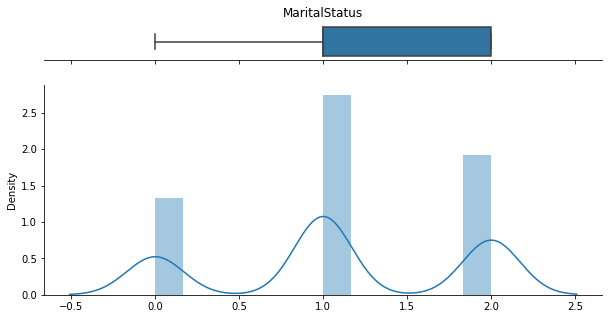

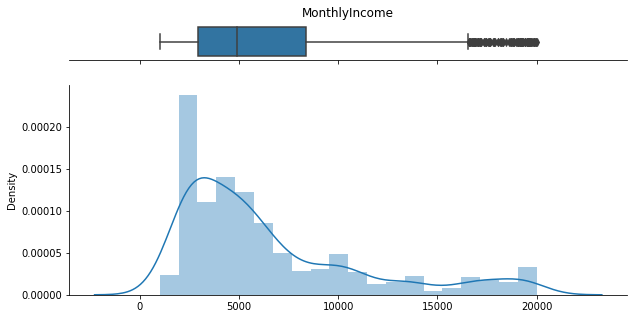

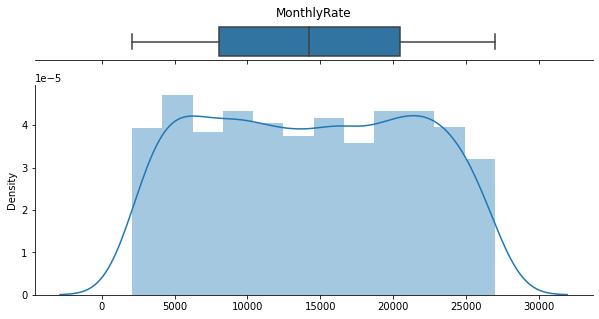

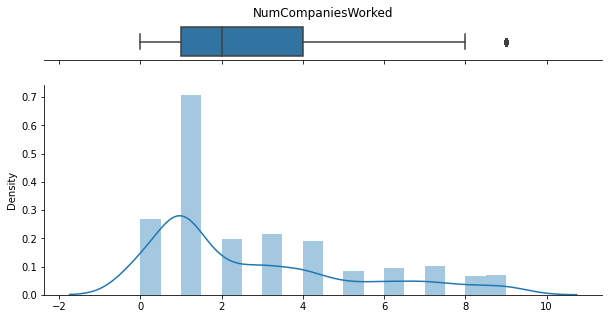

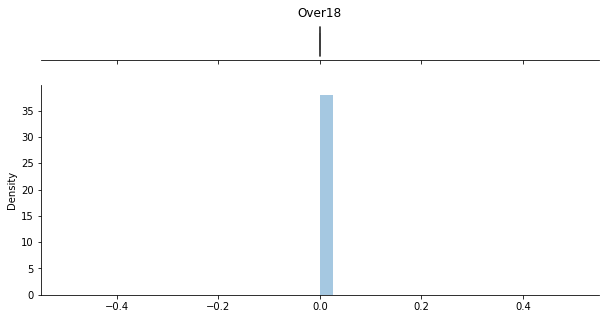

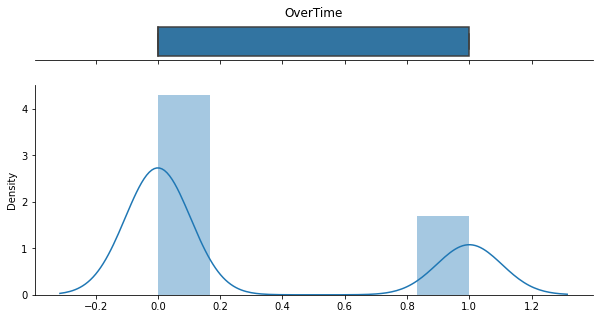

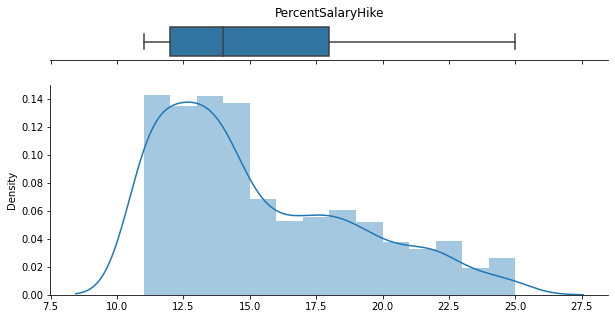

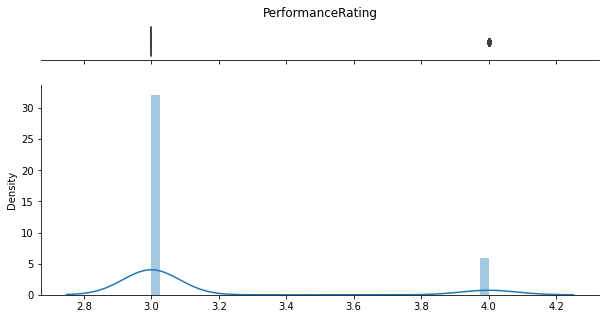

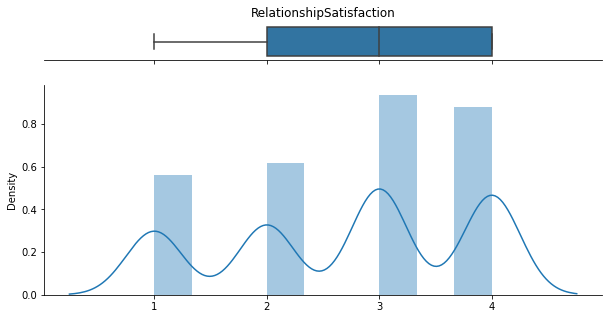

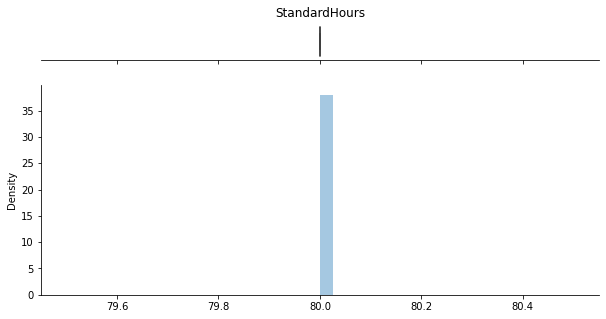

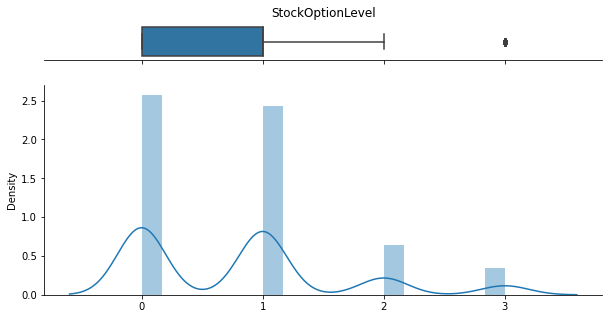

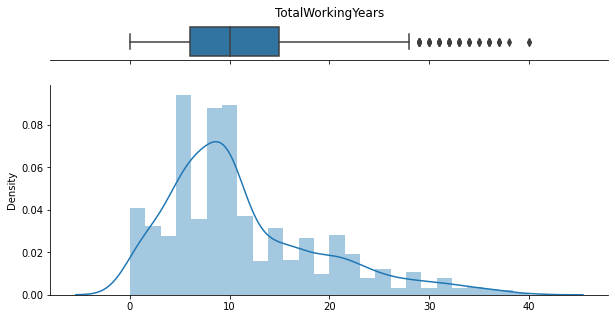

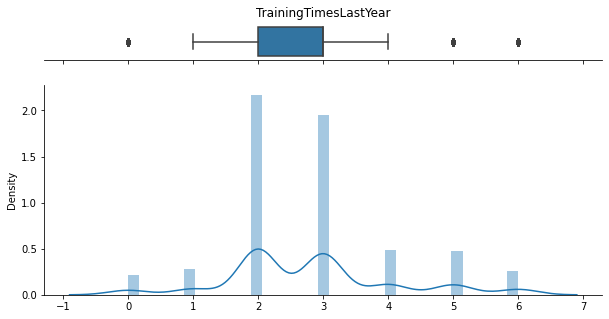

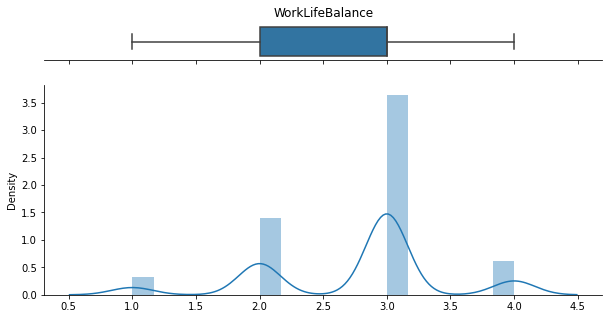

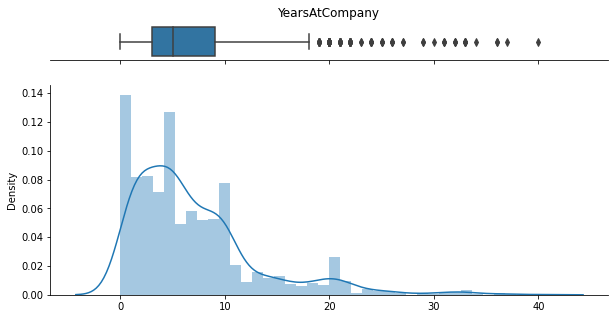

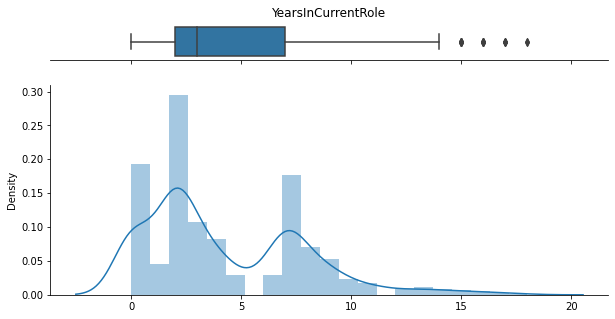

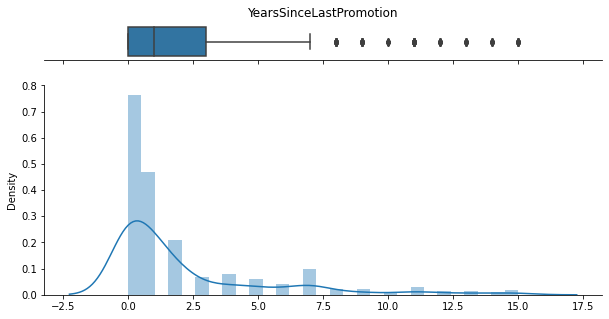

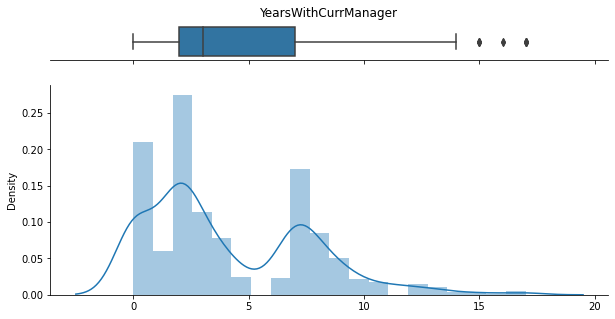

In [ ]:
# Filter/subset/clean the data according to your EDA findings
# Check for Outliers


for c in df.columns:
    fig, ax = plt.subplots(2, 
                           figsize = (10, 5),
                           sharex = True, 
                           gridspec_kw = {'height_ratios': (0.15, 0.85)})

    ax_box = ax[0]
    ax_box = sns.boxplot(df[c], ax = ax_box)
    ax_box.set(title = c, yticks = [], xlabel = '')
    sns.despine(ax = ax_box, left = True)
    
    ax_hist = ax[1]
    
    if c == 'Donated_Mar_2007':       
        ax_hist = sns.distplot(df[c], kde=False, ax = ax_hist)
        ax_hist.set(xlabel = '')
        sns.despine(ax = ax_hist)
    else:
        ax_hist = sns.distplot(df[c], ax = ax_hist)
        ax_hist.set(xlabel = '')
        sns.despine(ax = ax_hist)
        

plt.show()

# CatBoostClassifier On Whole Model (Train, test, split)

Split the data

In [ ]:
y = df.Attrition
X = df.drop('Attrition', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=46, stratify=y)

In [ ]:
#Create pool for eval data (TEST)
train = Pool(data=X_train, label=y_train)
test = Pool(data=X_test, label=y_test)


In [ ]:
model = CatBoostClassifier(learning_rate=0.03, iterations=100,
                           custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false','Accuracy','Precision','Recall', 'F1'])


In [ ]:
model.fit(train, 
          eval_set=test)
          #verbose=False)

print(model.get_best_score())

0:	learn: 0.6689830	test: 0.6706495	best: 0.6706495 (0)	total: 64.4ms	remaining: 6.37s
1:	learn: 0.6497358	test: 0.6528245	best: 0.6528245 (1)	total: 79.2ms	remaining: 3.88s
2:	learn: 0.6337626	test: 0.6370616	best: 0.6370616 (2)	total: 86.6ms	remaining: 2.8s
3:	learn: 0.6137742	test: 0.6184707	best: 0.6184707 (3)	total: 99.4ms	remaining: 2.39s
4:	learn: 0.5969278	test: 0.6023068	best: 0.6023068 (4)	total: 104ms	remaining: 1.98s
5:	learn: 0.5824922	test: 0.5887662	best: 0.5887662 (5)	total: 112ms	remaining: 1.76s
6:	learn: 0.5685871	test: 0.5750554	best: 0.5750554 (6)	total: 121ms	remaining: 1.6s
7:	learn: 0.5522073	test: 0.5605742	best: 0.5605742 (7)	total: 132ms	remaining: 1.52s
8:	learn: 0.5377030	test: 0.5479249	best: 0.5479249 (8)	total: 140ms	remaining: 1.42s
9:	learn: 0.5260810	test: 0.5365577	best: 0.5365577 (9)	total: 149ms	remaining: 1.34s
10:	learn: 0.5127826	test: 0.5248136	best: 0.5248136 (10)	total: 158ms	remaining: 1.27s
11:	learn: 0.5020775	test: 0.5154689	best: 0.51546

In [ ]:
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)

In [ ]:
def show_summary_report(actual, prediction, probabilities):

    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_score(actual, prediction))
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_score(actual, prediction))
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_score(actual, prediction))
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_score(actual, probabilities[:, 1]))
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities[:, 1])
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')


    plt.show()

Accuracy : 0.8639 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8235 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.1972 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8124                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


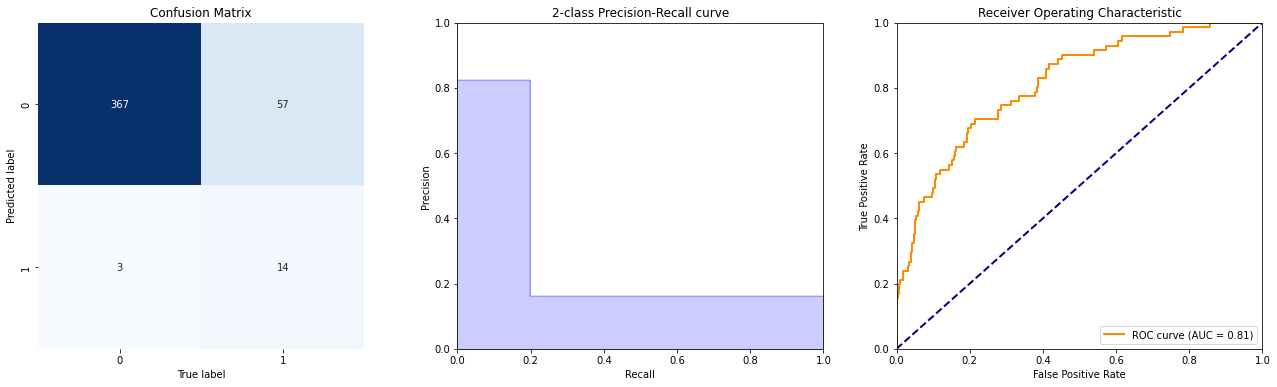

In [ ]:
show_summary_report(y_test, y_test_pred, y_test_prob)

FPR/FNR plot

In [ ]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = test
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)


In [ ]:
#Create fpr and fnr curves
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

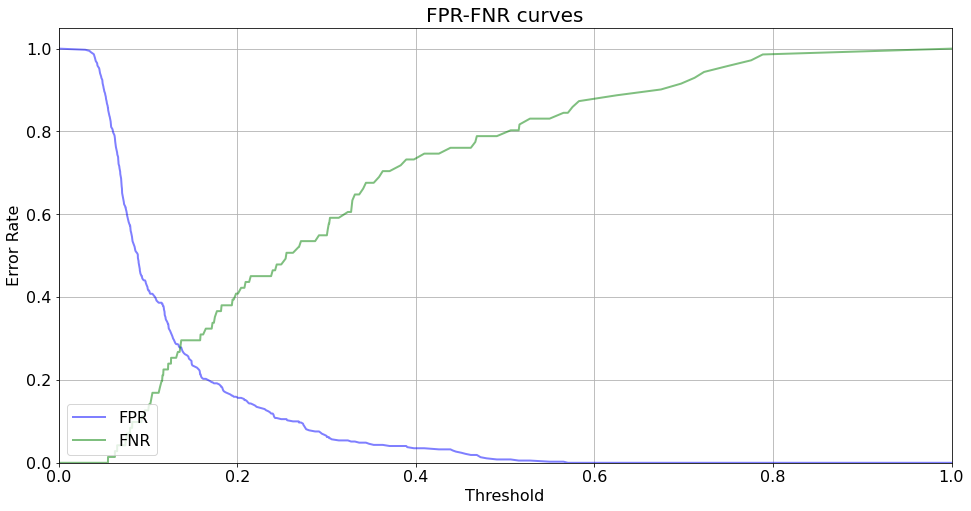

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

# Feature Importance

In [ ]:
featurep = model.get_feature_importance(prettified=True)
featurep

,Feature Id,Importances
0,OverTime,14.614191
1,JobLevel,7.094910
2,MonthlyIncome,6.078954
3,StockOptionLevel,5.659778
4,JobSatisfaction,5.466272
5,Age,4.648596
6,EnvironmentSatisfaction,4.383790
7,NumCompaniesWorked,4.287632
8,YearsWithCurrManager,3.686957
9,MaritalStatus,3.523213


In [ ]:
import plotly.express as px
fig = px.bar(featurep, x='Importances', y='Feature Id', title="Feature Importances on Attrition")
fig.show()

# Shap Values

In [ ]:
#create feature list
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [ ]:
import shap

In [ ]:
shap_values = model.get_feature_importance(test, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(441, 34)


In [ ]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

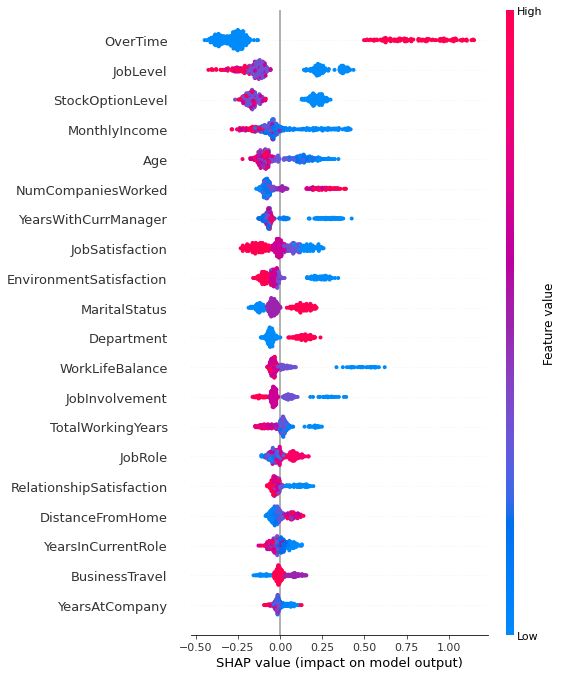

In [ ]:
shap.summary_plot(shap_values, X_test)

# Feature Selection

In [ ]:
df.corr()['Attrition'].sort_values()

TotalWorkingYears          -0.171063
JobLevel                   -0.169105
YearsInCurrentRole         -0.160545
MonthlyIncome              -0.159840
Age                        -0.159205
YearsWithCurrManager       -0.156199
StockOptionLevel           -0.137145
YearsAtCompany             -0.134392
JobInvolvement             -0.130016
JobSatisfaction            -0.103481
EnvironmentSatisfaction    -0.103369
WorkLifeBalance            -0.063939
TrainingTimesLastYear      -0.059478
DailyRate                  -0.056652
RelationshipSatisfaction   -0.045872
YearsSinceLastPromotion    -0.033019
Education                  -0.031373
PercentSalaryHike          -0.013478
EmployeeNumber             -0.010577
HourlyRate                 -0.006846
BusinessTravel              0.000074
PerformanceRating           0.002889
MonthlyRate                 0.015170
EducationField              0.026846
Gender                      0.029453
NumCompaniesWorked          0.043494
Department                  0.063991
J

Select variabels obove .10 or -.10 to begin.

TotalWorkingYears, JobLevel, YearsInCurrentRole, Age, YearsWithCurrManager, StockOptionLevel, YearsAtCompany, JobInvolvement, JobSatisfaction, EnvironmentSatisfaction > -.10

OverTime, MaritalStatus > 0.10

Check these vairbale with feature importance. Add features which have a high value but arent in correlation selection.

In [ ]:
featurep

,Feature Id,Importances
0,OverTime,14.614191
1,JobLevel,7.094910
2,MonthlyIncome,6.078954
3,StockOptionLevel,5.659778
4,JobSatisfaction,5.466272
5,Age,4.648596
6,EnvironmentSatisfaction,4.383790
7,NumCompaniesWorked,4.287632
8,YearsWithCurrManager,3.686957
9,MaritalStatus,3.523213


MonthlyIncome (6.078954), NumCompaniesWorked (4.287632), WorkLifeBalance(3.460420) added to features

Run Model with selected features

In [ ]:
#Create New X list for features

X = df[['MonthlyIncome', 'NumCompaniesWorked', 'WorkLifeBalance', 'OverTime', 'MaritalStatus', 'TotalWorkingYears', 'JobLevel', 'YearsInCurrentRole', 'Age', 'YearsWithCurrManager', 'StockOptionLevel', 'YearsAtCompany', 'JobInvolvement', 'JobSatisfaction', 'EnvironmentSatisfaction']]
y= df['Attrition']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=46, stratify=y)

In [ ]:
trainf = Pool(data=X_train, label=y_train)
testf = Pool(data=X_test, label=y_test)

In [ ]:
model = CatBoostClassifier(learning_rate=0.03, iterations=100,
                           custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false','Accuracy','Precision','Recall', 'F1'])


In [ ]:
model.fit(trainf,
          eval_set=testf)
          #verbose=False)

print(model.get_best_score())

0:	learn: 0.6805068	test: 0.6806872	best: 0.6806872 (0)	total: 1.39ms	remaining: 138ms
1:	learn: 0.6666574	test: 0.6675442	best: 0.6675442 (1)	total: 2.58ms	remaining: 126ms
2:	learn: 0.6543421	test: 0.6552685	best: 0.6552685 (2)	total: 3.74ms	remaining: 121ms
3:	learn: 0.6432649	test: 0.6451896	best: 0.6451896 (3)	total: 7.56ms	remaining: 182ms
4:	learn: 0.6320036	test: 0.6348519	best: 0.6348519 (4)	total: 9.53ms	remaining: 181ms
5:	learn: 0.6209330	test: 0.6244395	best: 0.6244395 (5)	total: 11.4ms	remaining: 179ms
6:	learn: 0.6098957	test: 0.6142008	best: 0.6142008 (6)	total: 13.1ms	remaining: 175ms
7:	learn: 0.6012799	test: 0.6057254	best: 0.6057254 (7)	total: 14.7ms	remaining: 169ms
8:	learn: 0.5912256	test: 0.5962818	best: 0.5962818 (8)	total: 16ms	remaining: 161ms
9:	learn: 0.5826942	test: 0.5886599	best: 0.5886599 (9)	total: 17.9ms	remaining: 161ms
10:	learn: 0.5748038	test: 0.5815146	best: 0.5815146 (10)	total: 19.6ms	remaining: 158ms
11:	learn: 0.5652832	test: 0.5726104	best: 

In [ ]:
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)

Accuracy : 0.8571 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7500 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.1690 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8043                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


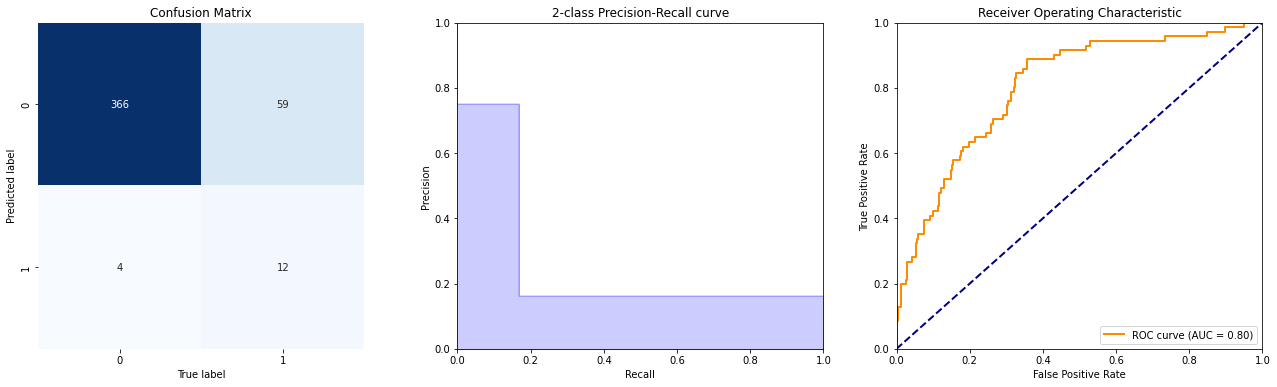

In [ ]:
show_summary_report(y_test, y_test_pred, y_test_prob)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

Performance Descreased with Feature Selection

# Cross Validation

In [ ]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 100
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=False,
    stratified=False,
    verbose=True
)

Training on fold [0/5]
0:	learn: 0.4623137	test: 0.4566102	best: 0.4566102 (0)	total: 37.9ms	remaining: 3.75s
1:	learn: 0.4259188	test: 0.4165335	best: 0.4165335 (1)	total: 43.8ms	remaining: 2.14s
2:	learn: 0.3629618	test: 0.3809200	best: 0.3809200 (2)	total: 60.8ms	remaining: 1.97s
3:	learn: 0.3556341	test: 0.3680140	best: 0.3680140 (3)	total: 65.3ms	remaining: 1.57s
4:	learn: 0.3298170	test: 0.3622467	best: 0.3622467 (4)	total: 78.2ms	remaining: 1.49s
5:	learn: 0.3120523	test: 0.3577041	best: 0.3577041 (5)	total: 91.6ms	remaining: 1.43s
6:	learn: 0.2921975	test: 0.3658714	best: 0.3577041 (5)	total: 105ms	remaining: 1.4s
7:	learn: 0.2758468	test: 0.3529681	best: 0.3529681 (7)	total: 118ms	remaining: 1.36s
8:	learn: 0.2585048	test: 0.3526633	best: 0.3526633 (8)	total: 144ms	remaining: 1.45s
9:	learn: 0.2455183	test: 0.3519060	best: 0.3519060 (9)	total: 161ms	remaining: 1.45s
10:	learn: 0.2317685	test: 0.3553193	best: 0.3519060 (9)	total: 193ms	remaining: 1.56s
11:	learn: 0.2143731	test

# Grid Search

Perform grid search back with full data set

In [ ]:
y = df.Attrition
X = df.drop('Attrition', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=46, stratify=y)

In [ ]:
#Create pool for eval data (TEST)
train = Pool(data=X_train, label=y_train)
test = Pool(data=X_test, label=y_test)


In [ ]:
model = CatBoostClassifier(learning_rate=0.03, iterations=100,
                           custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false','Accuracy','Precision','Recall', 'F1'])

In [ ]:
grid = {
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}
grid_search_results = model.grid_search(grid, train, shuffle=False, verbose=3, plot=False)

0:	learn: 0.6735142	test: 0.6723911	best: 0.6723911 (0)	total: 3.49ms	remaining: 346ms
1:	learn: 0.6527540	test: 0.6509807	best: 0.6509807 (1)	total: 8.95ms	remaining: 438ms
2:	learn: 0.6342722	test: 0.6328199	best: 0.6328199 (2)	total: 13.2ms	remaining: 426ms
3:	learn: 0.6170796	test: 0.6162265	best: 0.6162265 (3)	total: 17.5ms	remaining: 420ms
4:	learn: 0.6047893	test: 0.6038241	best: 0.6038241 (4)	total: 22ms	remaining: 418ms
5:	learn: 0.5901190	test: 0.5874137	best: 0.5874137 (5)	total: 26.8ms	remaining: 420ms
6:	learn: 0.5768372	test: 0.5744606	best: 0.5744606 (6)	total: 30.1ms	remaining: 400ms
7:	learn: 0.5651396	test: 0.5622437	best: 0.5622437 (7)	total: 32.7ms	remaining: 376ms
8:	learn: 0.5508219	test: 0.5483248	best: 0.5483248 (8)	total: 34.5ms	remaining: 348ms
9:	learn: 0.5371692	test: 0.5346457	best: 0.5346457 (9)	total: 36.3ms	remaining: 327ms
10:	learn: 0.5282872	test: 0.5258681	best: 0.5258681 (10)	total: 38.2ms	remaining: 309ms
11:	learn: 0.5186718	test: 0.5162333	best: 

In [ ]:
print(model.get_best_score())

{'learn': {'Recall': 0.6746987951807228, 'Accuracy': 0.9465500485908649, 'F1': 0.8028673835125447, 'Logloss': 0.16706761637844114, 'Precision': 1.0, 'AUC': 0.9854877214536012}}


In [ ]:
predicted = model.predict_proba(test)
predicted[:3]

array([[0.9165, 0.0835],
       [0.9131, 0.0869],
       [0.9576, 0.0424]])

In [ ]:
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)

Accuracy : 0.8571 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6538 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.2394 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7978                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


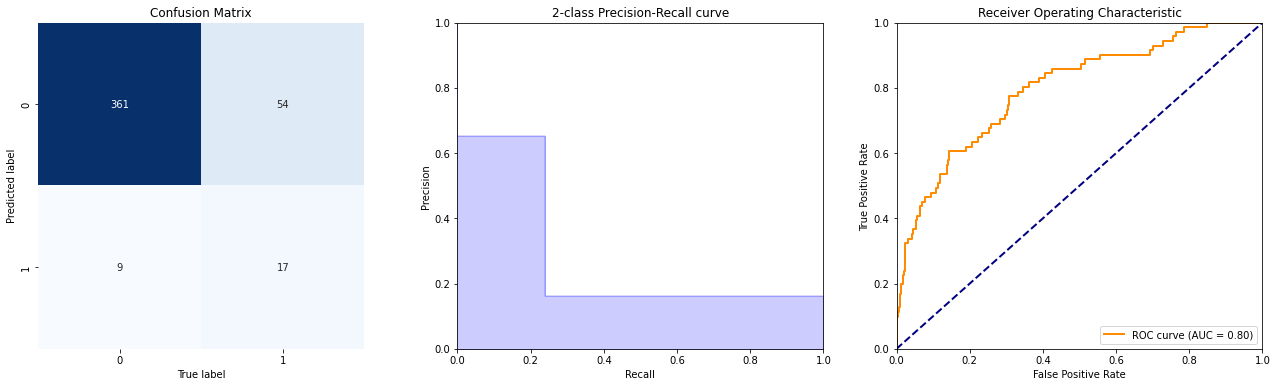

In [ ]:
show_summary_report(y_test, y_test_pred, y_test_prob)

Results lowered after grid search

# Test Scores for Other Methods (decision trees, random forest, XGboost)

Decision Tree

In [ ]:
cart = DecisionTreeClassifier()
cart.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
# Evaluate model against test set
y_test_pred = cart.predict(X_test)
y_test_prob = cart.predict_proba(X_test)

Accuracy : 0.7823 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.3239 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.3239 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5971                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


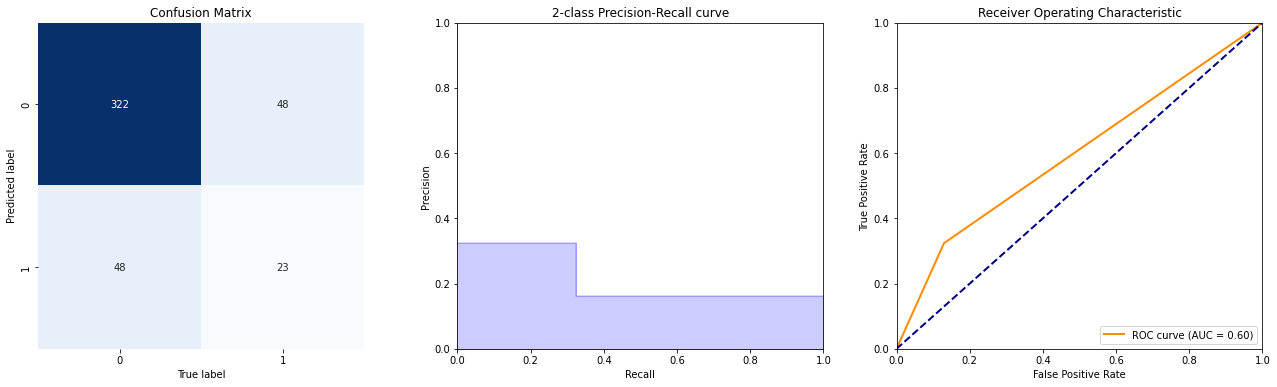

In [ ]:
show_summary_report(y_test, y_test_pred, y_test_prob)

ADA boost

In [ ]:
#ADABOOST
num_trees = 100
model = AdaBoostClassifier(n_estimators = num_trees, random_state = 46)
model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=46)

In [ ]:
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)

Accuracy : 0.8594 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5849 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4366 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7553                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


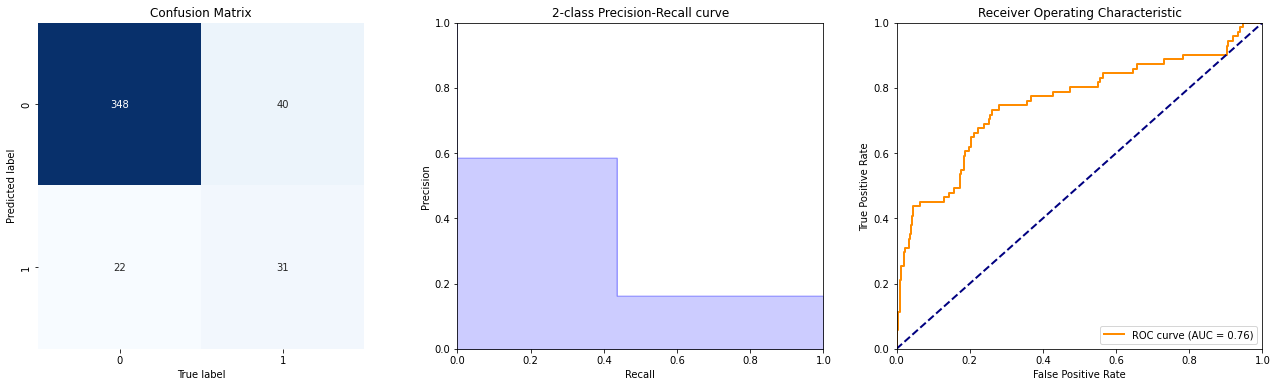

In [ ]:
show_summary_report(y_test, y_test_pred, y_test_prob)

Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators = 10, random_state = 1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [ ]:
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)

Accuracy : 0.8481 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6111 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.1549 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7144                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


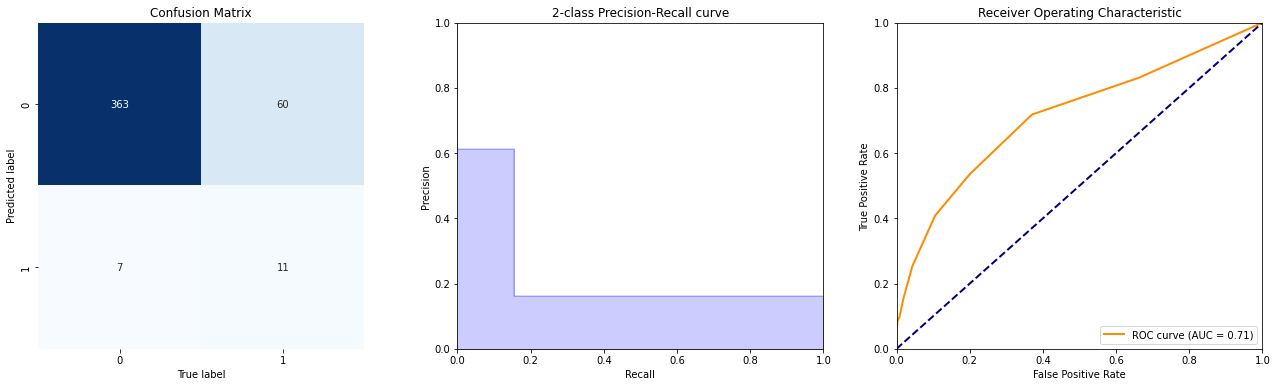

In [ ]:
show_summary_report(y_test, y_test_pred, y_test_prob)

XG boost

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(random_state=42)

In [ ]:
y_test_pred = xgb_model.predict(X_test)
y_test_prob = xgb_model.predict_proba(X_test)

Accuracy : 0.8503 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5862 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.2394 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7813                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


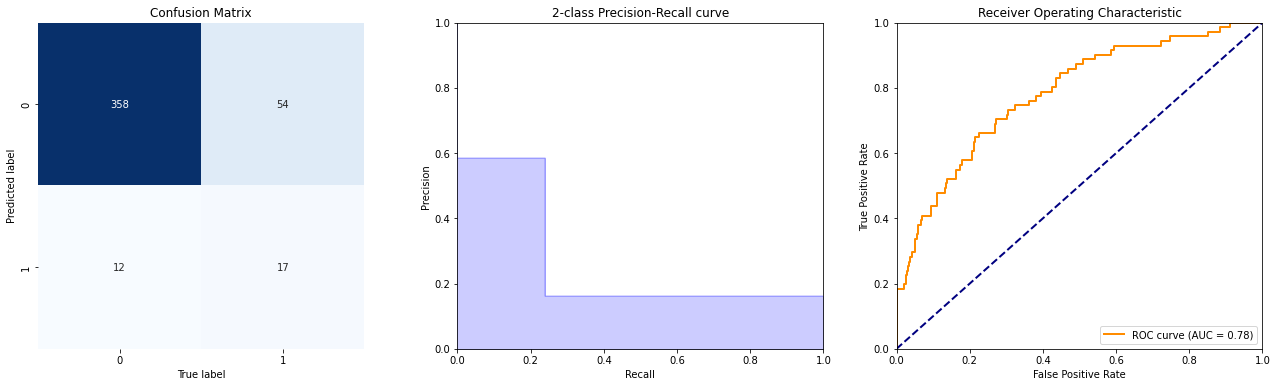

In [ ]:
show_summary_report(y_test, y_test_pred, y_test_prob)

# Results Table and Conclusion

In [ ]:
results = {'Method' : ['Cat Boost','Cat BoostCV', 'Cat BoostGS','Cat BoostFS','Decision Tree', 'ADA Boost', 'Random Forest','XG Boost'], 
           'Accuracy' : ['0.8639', '0.8481', '0.8571', '0.8571','0.7619','0.8594', '0.8481', '0.8503'], 
           'Precision': ['0.8235', '0.6111', '0.7500','0.6538','0.2821','0.5849', '0.6111', '0.5862'],
           'Recall' : ['0.1972', '0.1549', '0.1690', '0.2394','0.3099','0.4366', '0.1549', '0.2394'],
           'ROC AUC' : ['0.8124', '0.7144', '0.8043','0.7978', '0.5793','0.7553','0.7144','0.7813']}

results = pd.DataFrame(results)

      

In [ ]:
results

,Method,Accuracy,Precision,Recall,ROC AUC
0,Cat Boost,0.8639,0.8235,0.1972,0.8124
1,Cat BoostCV,0.8481,0.6111,0.1549,0.7144
2,Cat BoostGS,0.8571,0.7500,0.1690,0.8043
3,Cat BoostFS,0.8571,0.6538,0.2394,0.7978
4,Decision Tree,0.7619,0.2821,0.3099,0.5793
5,ADA Boost,0.8594,0.5849,0.4366,0.7553
6,Random Forest,0.8481,0.6111,0.1549,0.7144
7,XG Boost,0.8503,0.5862,0.2394,0.7813


**Conclusion**

Catboost was the best performing method as it had the highest accuracy, precision and ROC AUS. Due to its high precision it did have quite a low recall, especially compared to other methods. Catboost accuracy and ROC AUS was only slightly better than most other methods but it really excelled in precision when compared to other methods, having a much higher score than all others. 

When applying grid search to catboost it lowered performance on all metrics. When applying feature selection it also lowered all metrics except recall, but due to this precision lowered significantly.

In conclusion it is clear that Cat Boost is the best method for claffication on this dataset, beating every other method in all metrics. It also worked best on its own before using grid search or feature selection. This shows that Cat Boost is a very effective and effecient method for prediction on this dataset. 